# Fusion gene domain architecture survival analysis

Here I am exploring the effect of domain architecture n-grams on predicting patient survival within the TCGA cohort. This will be both pan-cancer and then specific to individual cancers.

There are a few dependency files that will be generated from the baseline analysis and should be ensured to be present.

In [1]:
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from pybiomart import Dataset
import generateCompleteProteome
import ngramUtilities

In [2]:
# Creating some default parameters for future plots.
plt.rcParams['font.size'] = 5
plt.rcParams['axes.labelsize'] = 5
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams['savefig.bbox'] = 'tight'
plt.rcParams['savefig.pad_inches'] = 0.01


In [3]:
# Importing the clinical dataset, n-gram results, fusion gene database, and complete proteome n-gram network.

# Patient clinical data
pt_clinical = pd.read_csv('tcga_clinical_data.tsv', sep = '\t')

# pybiomart database for gene name conversions
dataset = Dataset(host = 'http://www.ensembl.org', name='hsapiens_gene_ensembl',)
gene_ID_conv = dataset.query(attributes=['ensembl_gene_id', 'external_gene_name','external_synonym','uniprotswissprot', 'version'])
gene_ID_conv_clean = gene_ID_conv.copy()
gene_ID_conv_clean.dropna(axis=0,subset=['Gene name','Gene Synonym'], inplace=True, how='all')

# Fusion gene dataset
fusion_files = 'ChimerSeq4.xlsx'
fusion_db = pd.read_excel(fusion_files)
# Fixing gene names that were converted to dates due to Excel format
for idx, row in fusion_db.iterrows():
    full_fusion = row['Fusion_pair'].upper().split('-')
    five_gene = row['H_gene']
    three_gene = row['T_gene']
    if full_fusion[0] != five_gene:
        fusion_db.at[idx, 'H_gene'] = full_fusion[0]
    if full_fusion[1] != three_gene:
        fusion_db.at[idx, 'T_gene'] = full_fusion[1]

# Creating dataframe that will be used for further analysis on specific subsets of genes
columns_to_keep = ['BarcodeID','Fusion_pair','H_gene','H_chr','H_position','H_strand','T_gene','T_chr','T_position','T_strand','Genome_Build_Version','Highly_Reliable_Seq', 'Frame','Chr_info','Cancertype']
fusion_db_filt = fusion_db.copy()
fusion_db_filt = fusion_db_filt.filter(items=columns_to_keep, axis=1)


# Importing the full proteome n-gram analysis results
removed_ngrams = generateCompleteProteome.import_removed_ngrams('Current_Complete_Proteome_Removed_Ngrams.csv',rm_dir='./')
adj_df = generateCompleteProteome.import_adjacency_from_json(adj_dir='./')
ref_df, interpro_dict = generateCompleteProteome.import_proteome_files()
_,full_ngram_dict = ngramUtilities.get_ngrams_from_df(ref_df,[k for k in interpro_dict.keys()],100)
temp_rm = set(full_ngram_dict.keys()).difference(adj_df.columns.tolist())
rm_overlap_check = temp_rm.difference(removed_ngrams)
nat_ngrams_ids = set(adj_df.columns).union(temp_rm)

# Recreating the adjacency matrix and removed ngrams list, but with legible names for downstream work.
ngram_convert={}
for ngram in nat_ngrams_ids:
    ngram_spl = ngram.split('|')
    ngram_conv = []
    for n in ngram_spl:
        ngram_conv.append(interpro_dict[n])
    ngram_conv = '|'.join(ngram_conv)
    ngram_convert[ngram] = ngram_conv

removed_ngrams=temp_rm
leg_adj = adj_df.copy()
leg_adj.rename(index=ngram_convert, columns=ngram_convert, inplace=True)
leg_removed_ngrams = [ngram_convert[k] for k in removed_ngrams]
nat_ngrams = [k for k in ngram_convert.values()]

In [4]:
import json
json_file = 'Fusion Patient Complete Information.json'
with open(json_file) as j_file:
    all_pts = json.load(j_file)

json_file = 'Fusion Patient Fusion Categories.json'
with open(json_file) as j_file:
    fusion_categories = json.load(j_file)


In [5]:
# Generating the base n-gram network

# Generate the network for the original canonical human proteome
G = nx.from_pandas_adjacency(adj_df)

# Get a couple of key parameters that can potentially change
cc_orig = nx.number_connected_components(G)
isol_orig = nx.number_of_isolates(G)
artic_orig = len(list(nx.articulation_points(G)))
proteome_gross_topo = [cc_orig, isol_orig, artic_orig]
ref_data = [ref_df, adj_df, removed_ngrams, interpro_dict, proteome_gross_topo]

In [6]:
# Loading in the list of pY and pST kinases to allow for annotating patients as having one or the other if they have a kinase
pY_ref = pd.read_csv('Human_tyr-kinase_Only.csv')

# Given that most of the HRs of the fusions shows a very wide CI interval that suggests that this likely too wide of a stratification that by itself is not distinct enough. So as a proof of concept I am checking whether there is kinase domain and if necessary stratifying if it is based on tyrosine or ST
p_cnt = 0
for pt,dets in all_pts.items():
    if 'IPR000719' in dets['Interpro Domain Architecture IDs']:
        py_flag = False
        pst_flag = False
        for gene,gene_dets in dets['Genes'].items():
            # Checking if its contribution is part of the fusion gene or it is just simply a part of it
            if 'IPR000719' in gene_dets['Fusion Protein Contribution IDs']:    
                if gene_dets['UniProt ID'] in pY_ref['UniProt ID'].tolist():
                    py_flag = True
                else:
                    pst_flag = True
        
        if py_flag and pst_flag:
            dets['Kinase'] = 'Both'
        elif py_flag:
            dets['Kinase'] = 'pY'
        elif pst_flag:
            dets['Kinase'] = 'pST'

        p_cnt += 1
    else:
        dets['Kinase'] = 'None'


In [7]:
# Importing the patient clicial information and then checking if their domain architecture was one of those that contributed to changes in the network.
pt_OI_list = set()
for cancer,net_info in fusion_categories.items():
    for net_impact in net_info:
        pt_OI_list = pt_OI_list.union(net_info[net_impact]['Pt Members'])

In [8]:
# Getting the patient ids from the pts that have network changes
pt_ids = set()
for pt in pt_OI_list:
    pt_ids.add(all_pts[str(pt)]['Pt ID'][:-1])

In [9]:
pt_clinical_filt = pt_clinical.copy()
pt_clinical_filt.drop_duplicates(subset='Sample ID',inplace=True, keep='first')
pt_clinical_filt.index = pt_clinical_filt['Sample ID']

# Grabbing only columns of interest for downstream analysis.
cols_2_keep = ['Patient ID','Sample ID','Diagnosis Age','Cancer Type','TCGA PanCanAtlas Cancer Type Acronym','Disease Free (Months)','Disease Free Status','Months of disease-specific survival','Disease-specific Survival status','Overall Survival (Months)','Overall Survival Status']

pt_clinical_filt = pt_clinical_filt.filter(pt_ids, axis = 0).filter(cols_2_keep, axis=1)

In [10]:
pt_nofus_filt = pt_clinical.copy()
pt_nofus_filt.drop_duplicates(subset = 'Sample ID', inplace=True, keep='first')
pt_nofus_filt.index = pt_nofus_filt['Sample ID']
dbl_check_pts = set(pt_ids).intersection(pt_nofus_filt.index)
pt_nofus_filt= pt_nofus_filt.drop(dbl_check_pts,axis=0).filter(cols_2_keep, axis=1)

In [11]:
# Creating a TCGA sample id to patient id conversion dict
tcga_id_conv = {v['Pt ID']:k for k,v in all_pts.items() if int(k) in pt_OI_list}

In [12]:

# Checking to see how many patients have multiple fusions
multi_fus = {}
for fus,dets in all_pts.items():
    pt_id = dets['Pt ID']
    if tcga_id_conv[pt_id] != fus:
        if pt_id not in multi_fus:
            multi_fus[pt_id] = []
        multi_fus[pt_id].append(fus)

for pt in multi_fus:
    multi_fus[pt].append(tcga_id_conv[pt])

In [13]:
# Removing patients for the time being from those within the tcga conversion
for pt in multi_fus.keys():
    del tcga_id_conv[pt]

network_change_cats = {'AP Only':'Reinforcement',
                       'Interconnectedness':'Reinforcement',
                       'Unique Only':'Connect Components',
                       'CC Only':'Connect Components',
                       'Impactful':'Connect Components',
                       'No Change':'No Change',
                       'Empty Domain':'Unannotated Domains'}

In [14]:
pt_nofus_filt['Network Change'] = 'No Fusion'

In [15]:
# Getting each patient's impact on the network and appending it onto the clinical dataframe
cnt = 0
skpped_ids = set()
pt2kp = set()
for pt,row in pt_clinical_filt.iterrows():
    can = row['TCGA PanCanAtlas Cancer Type Acronym']
    pt_id = pt+'A'
    chck_dets = True
    
    # Note this is very inefficient and will absolutely need to change this is just to get the data quickly
    fusionOI = fusion_categories[can]
    if pt_id in tcga_id_conv.keys():
        ptOI = tcga_id_conv[pt_id]
    elif pt_id in multi_fus.keys():
        pt_clinical_filt.loc[pt, 'Network Change'] = 'Multiple Fusions'
        av = 0
        py_flag = False
        pst_flag = False
        for fus_sub in multi_fus[pt_id]:
            fus_sub = str(fus_sub)
            if all_pts[fus_sub]['Interpro Domain Architecture IDs'] != '':
                av += len(all_pts[fus_sub]['Interpro Domain Architecture IDs'].split('|'))

                # Finding out if a kinase domain is present:
                if 'IPR000719' in all_pts[fus_sub]['Interpro Domain Architecture IDs']:
                    
                    for gene,gene_dets in all_pts[fus_sub]['Genes'].items():
                        # Checking if its contribution is part of the fusion gene or it is just simply a part of it
                        if 'IPR000719' in gene_dets['Fusion Protein Contribution IDs']:    
                            if gene_dets['UniProt ID'] in pY_ref['UniProt ID'].tolist():
                                py_flag = True
                            else:
                                pst_flag = True
           
        if py_flag and pst_flag:
            pt_clinical_filt.loc[pt,'Kinase'] = 'Both'
        elif py_flag:
            pt_clinical_filt.loc[pt,'Kinase'] = 'pY'
        elif pst_flag:
            pt_clinical_filt.loc[pt,'Kinase'] = 'pST'
        else:         
            pt_clinical_filt.loc[pt,'Kinase'] = 'None'
        av = av/len(multi_fus[pt_id])
        chck_dets = False
        pt_clinical_filt.loc[pt,'Fusion Architecture Length'] = av
    # Checking a second version which is whether it ends with B instead
    pt_id = pt + 'B'
    if pt_id in tcga_id_conv.keys():
        ptOI = tcga_id_conv[pt_id]
    elif pt_id in multi_fus.keys():
        av = 0
        for fus_sub in multi_fus[pt_id]:
            if all_pts[fus_sub]['Interpro Domain Architecture IDs'] != '':
                av += len(all_pts[fus_sub]['Interpro Domain Architecture IDs'].split('|'))
                # Finding out if a kinase domain is present:
                if 'IPR000719' in all_pts[fus_sub]['Interpro Domain Architecture IDs']:
                    
                    for gene,gene_dets in all_pts[fus_sub]['Genes'].items():
                        # Checking if its contribution is part of the fusion gene or it is just simply a part of it
                        if 'IPR000719' in gene_dets['Fusion Protein Contribution IDs']:    
                            if gene_dets['UniProt ID'] in pY_ref['UniProt ID'].tolist():
                                py_flag = True
                            else:
                                pst_flag = True
           
        if py_flag and pst_flag:
            pt_clinical_filt.loc[pt,'Kinase'] = 'Both'
        elif py_flag:
            pt_clinical_filt.loc[pt,'Kinase'] = 'pY'
        elif pst_flag:
            pt_clinical_filt.loc[pt,'Kinase'] = 'pST'
        else:         
            pt_clinical_filt.loc[pt,'Kinase'] = 'None'
        av = av/len(multi_fus[pt_id])
        pt_clinical_filt.loc[pt, 'Network Change'] = 'Multiple Fusions'
   
        chck_dets = False
        pt_clinical_filt.loc[pt,'Fusion Architecture Length'] = av
    else:
        cnt += 1
        skpped_ids.add(pt)
    
    if chck_dets:
        for k,net_dets in fusionOI.items():
            if int(ptOI) in net_dets['Pt Members']:
                pt_netchange = k

        pt_clinical_filt.loc[pt, 'Network Change'] = network_change_cats[pt_netchange]
        pt_clinical_filt.loc[pt, 'Kinase'] = all_pts[ptOI]['Kinase']
        if all_pts[ptOI]['Interpro Domain Architecture IDs'] != '':
            pt_clinical_filt.loc[pt,'Fusion Architecture Length'] = len(all_pts[ptOI]['Interpro Domain Architecture IDs'].split('|'))
        else:
            pt_clinical_filt.loc[pt,'Fusion Architecture Length'] = 0

In [16]:
from lifelines import KaplanMeierFitter
from lifelines.statistics import pairwise_logrank_test, multivariate_logrank_test,logrank_test
from lifelines.plotting import add_at_risk_counts

In [17]:
# Filtering patients if they are missing data in the months for Overall Survival
pt_clinical_comp_OS = pt_clinical_filt.copy()
pt_clinical_comp_OS = pd.concat([pt_clinical_comp_OS, pt_nofus_filt])
pt_clinical_comp_OS.dropna(subset=['Disease-specific Survival status','Months of disease-specific survival'],inplace=True)

os_stat = pt_clinical_comp_OS['Disease-specific Survival status'].map(lambda x: int(x[0]))
os_mnths = pt_clinical_comp_OS['Months of disease-specific survival']
ix = (pt_clinical_comp_OS['Network Change'] == 'Reinforcement')
cc_ix = (pt_clinical_comp_OS['Network Change'] == 'Connect Components')
nc_ix = (pt_clinical_comp_OS['Network Change'] == 'No Change')
em_ix = (pt_clinical_comp_OS['Network Change'] == 'Unannotated Domains')
nofus_ix = (pt_clinical_comp_OS['Network Change'] == 'No Fusion')
multi_ix =(pt_clinical_comp_OS['Network Change'] == 'Multiple Fusions')

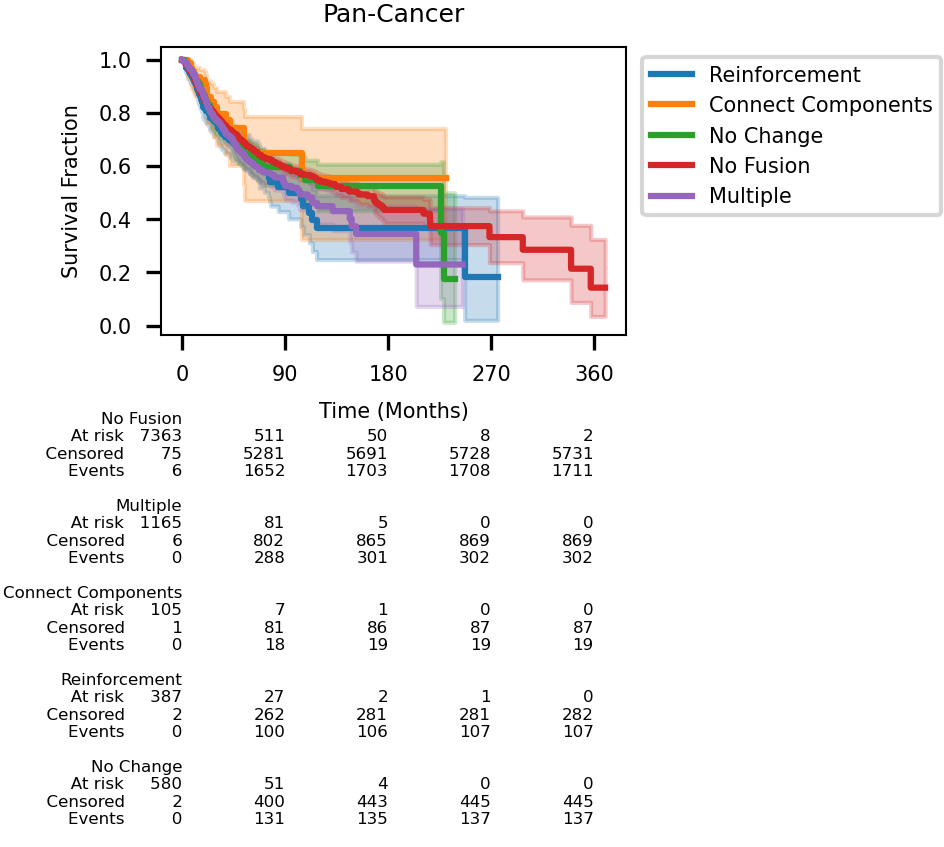

In [18]:
kmf_reinf = KaplanMeierFitter()
kmf_reinf.fit(os_mnths[ix], os_stat[ix], label = 'Reinforcement')
ax = kmf_reinf.plot_survival_function()
plt.ylabel('Survival Fraction')
plt.xlabel('Time (Months)')

kmf_CC = KaplanMeierFitter()
kmf_CC.fit(os_mnths[cc_ix], os_stat[cc_ix], label = 'Connect Components')
ax = kmf_CC.plot_survival_function(ax = ax)

kmf_NC = KaplanMeierFitter()
kmf_NC.fit(os_mnths[nc_ix], os_stat[nc_ix], label = 'No Change')
ax = kmf_NC.plot_survival_function(ax = ax)
#kmf.fit(os_mnths[em_ix], os_stat[em_ix], label = 'Unannotated Domains')
#ax = kmf.plot_survival_function(ax = ax)
kmf_noFus = KaplanMeierFitter()
kmf_noFus.fit(os_mnths[nofus_ix], os_stat[nofus_ix], label = 'No Fusion')
ax = kmf_noFus.plot_survival_function(ax = ax)

kmf_mulit = KaplanMeierFitter()
kmf_mulit.fit(os_mnths[multi_ix], os_stat[multi_ix], label = 'Multiple')
ax = kmf_mulit.plot_survival_function(ax = ax)
add_at_risk_counts(kmf_noFus,kmf_mulit,kmf_CC,kmf_reinf,kmf_NC,ax=ax, xticks=[0,90,180,270,360],fontsize=4)

plt.title('Pan-Cancer')
plt.gcf().set_size_inches(2,1.25)
plt.gcf().set_dpi(300)
ax.set_xticks([0,90,180,270,360])
ax.set_xlabel('Time (Months)')
l = ax.legend(bbox_to_anchor=(1.7,1))
plt.savefig('Figures/Manuscript Figures/Supplemental Figure 4 Fusion Gene Survivals/Pan Cancer Survival Detailed.svg')

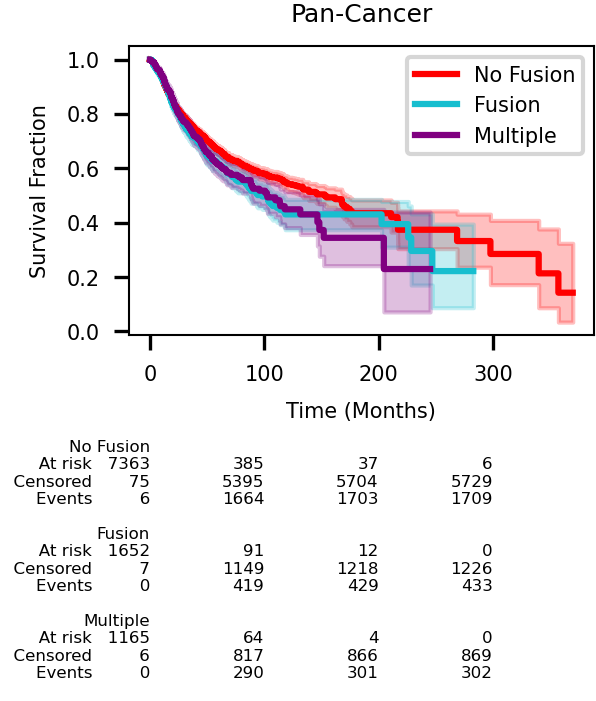

In [19]:
kmf_nofus = KaplanMeierFitter()
kmf_nofus.fit(os_mnths[nofus_ix], os_stat[nofus_ix], label = 'No Fusion')
ax = kmf_nofus.plot_survival_function(c='red')
kmf_fus = KaplanMeierFitter()
kmf_fus.fit(os_mnths[~(nofus_ix | multi_ix)], os_stat[~(nofus_ix | multi_ix)], label = 'Fusion')
ax = kmf_fus.plot_survival_function(ax = ax, c='tab:cyan')
kmf_multi = KaplanMeierFitter()
kmf_multi.fit(os_mnths[multi_ix], os_stat[multi_ix], label = 'Multiple')
ax = kmf_multi.plot_survival_function(ax = ax,c='purple')
plt.title('Pan-Cancer')
plt.gcf().set_size_inches(2,1.25)
plt.gcf().set_dpi(300)
plt.ylabel('Survival Fraction')
#res=pairwise_logrank_test(os_mnths,nofus_ix,os_stat)
#plt.annotate(f'p-val: {res.p_value[0]:.4f}',(300,0.8))
plt.xlabel('Time (Months)')
add_at_risk_counts(kmf_nofus,kmf_fus,kmf_multi,ax=ax, xticks=[0,100,200,300],fontsize=4,ypos=-0.25)
plt.savefig('Figures/Manuscript Figures/Supplemental Figure 4 Fusion Gene Survivals/Pan Cancer Fusion Survival.svg')

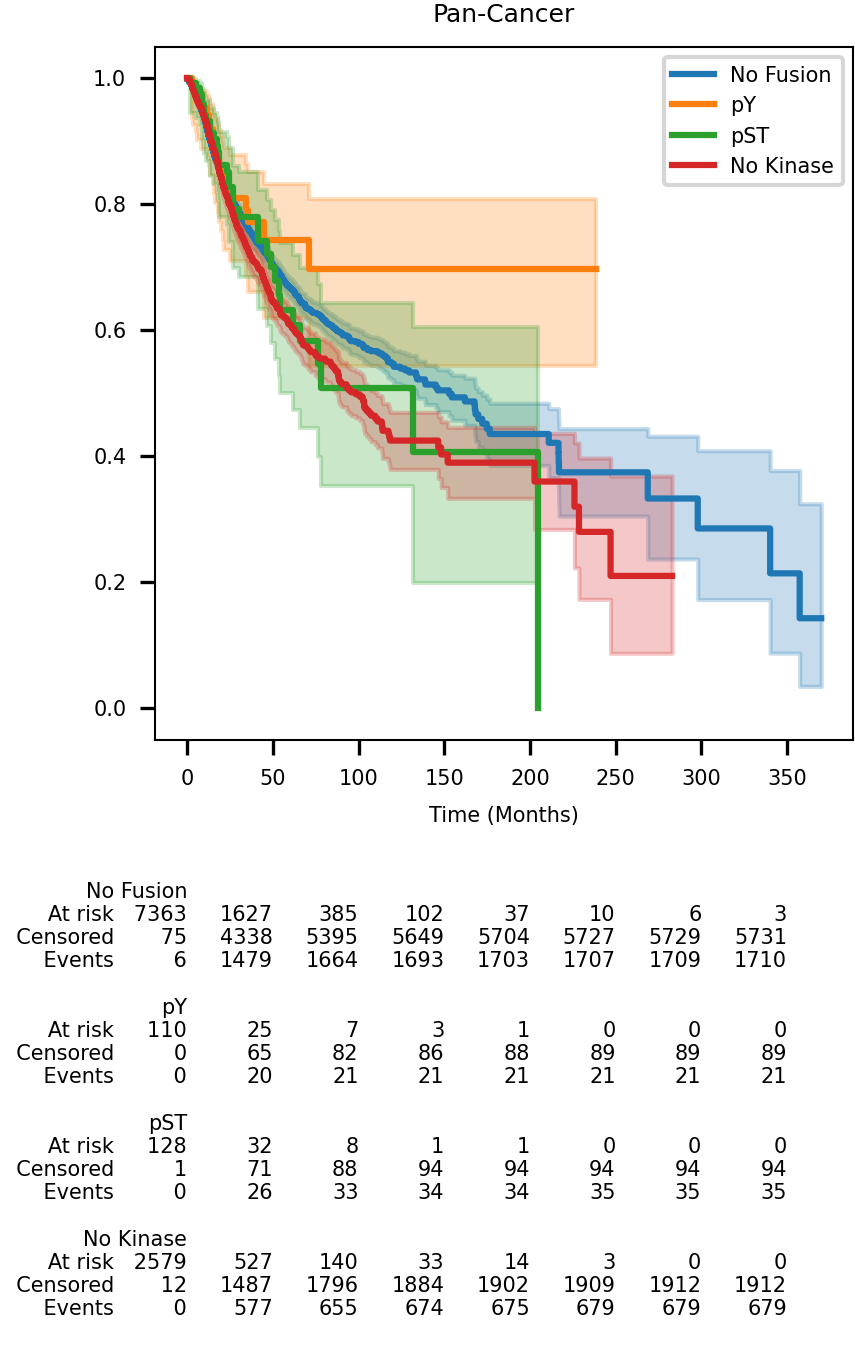

In [20]:
# Now creating the kinase KM plot with at risk counts
py_ix = (pt_clinical_comp_OS['Kinase'] == 'pY')
pst_ix = (pt_clinical_comp_OS['Kinase'] == 'pST')
nokin_ix = (pt_clinical_comp_OS['Kinase'] == 'None')
ax = kmf_nofus.plot_survival_function()
kmf_py = KaplanMeierFitter()
kmf_py.fit(os_mnths[py_ix], os_stat[py_ix], label = 'pY')
ax = kmf_py.plot_survival_function(ax = ax)
kmf_pst = KaplanMeierFitter()
kmf_pst.fit(os_mnths[pst_ix], os_stat[pst_ix], label = 'pST')
ax = kmf_pst.plot_survival_function(ax = ax)
kmf_nokin = KaplanMeierFitter()
kmf_nokin.fit(os_mnths[nokin_ix], os_stat[nokin_ix], label = 'No Kinase')
ax = kmf_nokin.plot_survival_function(ax = ax)
plt.xlabel('Time (Months)')
add_at_risk_counts(kmf_nofus,kmf_py,kmf_pst,kmf_nokin,ax=ax)

plt.title('Pan-Cancer')
plt.gcf().set_size_inches(3,3)
plt.gcf().set_dpi(300)
plt.ylabel('Survival Fraction')
plt.show()

With the pan-cancer analysis conducted now reducing the focus of individual cancers

In [21]:
from collections import Counter

In [22]:
pt_cnts = Counter(pt_clinical_comp_OS['TCGA PanCanAtlas Cancer Type Acronym'])
can_4_surv = [k for k,v in pt_cnts.items() if v > 300]

# Generating a simplified annotations of the network changes to allow for quick grouping and stratification.
fus_status_cats = {'Reinforcement':'Single',
                       'Connect Components':'Single',
                       'No Change':'Single',
                      'Unannotated Domains':'Single',
                      'No Fusion':'None',
                      'Multiple Fusions':'Multiple'}

pt_clinical_comp_OS['Fusion Status'] = pt_clinical_comp_OS['Network Change'].map(fus_status_cats)

In [24]:
# Doing an initial pass through for each cancer and determining whether the presence of a fusion gene suggests worse patient survival.
res_chck = {}
fus_impact_res = {}
fus_sig = []
simp_res = {}

for c in pt_cnts:

    # Getting the pts of interest
    can_clin = pt_clinical_comp_OS[pt_clinical_comp_OS['TCGA PanCanAtlas Cancer Type Acronym'] == c]
    os_stat = can_clin['Disease-specific Survival status'].map(lambda x: int(x[0]))
    os_mnths = can_clin['Months of disease-specific survival']
    
    # Designating patients as either having a fusion, a single fusion or multiple
    nofus_ix = (can_clin['Network Change'] == 'No Fusion')
    multi_ix =(can_clin['Network Change'] == 'Multiple Fusions')
    single_fus_ix = (~can_clin['Network Change'].isin(['Multiple Fusions', 'No Fusion']))

    # Getting a baseline comparison of the different fusion status of patients (none, single, v multiple)
    multi_res = multivariate_logrank_test(os_mnths, can_clin['Fusion Status'], os_stat)
    fus_impact_res[c] = multi_res
    # Want to make sure there is some statistically relevant difference driven by the presence of fusion gene(s)
    if multi_res.p_value <= 0.05 or c in ['BRCA', 'GBM','OV']:
        fus_sig.append(c)
        # Putting the summary of the results into a dictionary to analyze closer:
        res1 = pairwise_logrank_test(os_mnths, can_clin['Fusion Status'], os_stat).summary
        res_chck[c] = res1
        kmf = KaplanMeierFitter()
        kmf.fit(os_mnths[single_fus_ix], os_stat[single_fus_ix], label = 'Fusion')
        ax = kmf.plot_survival_function(c='tab:cyan')
        kmf.fit(os_mnths[nofus_ix], os_stat[nofus_ix], label = 'No Fusion')
        ax = kmf.plot_survival_function(ax = ax,c='red')
        kmf.fit(os_mnths[multi_ix], os_stat[multi_ix], label = 'Multiple')
        ax = kmf.plot_survival_function(ax = ax,c='purple')
        plt.title(f'{c}: n = {pt_cnts[c]}')
        plt.gcf().set_size_inches(1.5,1.5)
        plt.gcf().set_dpi(300)
        if c == 'KICH' or c == 'OV':
            l = plt.legend()
            l.set_bbox_to_anchor([1.6,1.0])
        else:
            plt.legend().remove()
        plt.gcf().set_dpi(200)
        plt.ylabel('Survival Fraction')
        plt.xlabel('Time (Months)')
        res=pairwise_logrank_test(os_mnths,can_clin['Fusion Status'],os_stat)
        simp_res[c] = res
        plt.savefig(f'Figures/Manuscript Figures/Supplemental Figure 5 Individual Cancer Simple Fusion Survivals/{c}.svg')
        # So that there are not all the plots here
        plt.close()

In [28]:
# Now checking for domain architecture impacts on the n-gram network
detailed_pw_stats ={}

for c in pt_cnts:

    # Getting the pts of interest
    can_clin = pt_clinical_comp_OS[pt_clinical_comp_OS['TCGA PanCanAtlas Cancer Type Acronym'] == c]
    can_clin = can_clin[can_clin['Network Change'].isin(['Connect Components','No Fusion','No Change','Reinforcement'])]
    os_stat = can_clin['Disease-specific Survival status'].map(lambda x: int(x[0]))
    os_mnths = can_clin['Months of disease-specific survival']
    ix = (can_clin['Network Change'] == 'Reinforcement')
    cc_ix = (can_clin['Network Change'] == 'Connect Components')
    nc_ix = (can_clin['Network Change'] == 'No Change')
    #em_ix = (can_clin['Network Change'] == 'Unannotated Domains')
    nofus_ix = (can_clin['Network Change'] == 'No Fusion')

    # Checking if any of the network changes are associated with a statistically significant change in survival. For any that are found to have some effect creating plots for that.
    res1 = multivariate_logrank_test(os_mnths,can_clin['Network Change'], os_stat)
    if res1.p_value <= 0.05 or c == 'BRCA':
        kmf = KaplanMeierFitter()
        kmf.fit(os_mnths[nofus_ix], os_stat[nofus_ix], label = 'No Fusion')
        ax = kmf.plot_survival_function()
        if any(ix):
            kmf_re = KaplanMeierFitter()
            kmf_re.fit(os_mnths[ix], os_stat[ix], label = 'Reinforcement')
            ax = kmf_re.plot_survival_function(ax = ax)
        if any(cc_ix):
            kmf_CC = KaplanMeierFitter()
            kmf_CC.fit(os_mnths[cc_ix], os_stat[cc_ix], label = 'Connect Components')
            ax = kmf_CC.plot_survival_function(ax = ax)
        if any(nc_ix):
            kmf_nc = KaplanMeierFitter()
            kmf_nc.fit(os_mnths[nc_ix], os_stat[nc_ix], label = 'No Change')
            ax = kmf_nc.plot_survival_function(ax = ax)
        add_at_risk_counts(kmf, kmf_re, kmf_CC, kmf_nc)
        #kmf.fit(os_mnths[em_ix], os_stat[em_ix], label = 'Unannotated Domains')
        #ax = kmf.plot_survival_function(ax = ax)
        res2 = pairwise_logrank_test(os_mnths, can_clin['Network Change'], os_stat)
        detailed_pw_stats[c] = res2.summary
        plt.title(f'{c}: n = {pt_cnts[c]}')
        plt.gcf().set_size_inches(2,1.5)
        #l = plt.legend()
        #plt.legend().remove()
        plt.gcf().set_dpi(300)
        plt.ylabel('Survival Fraction')
        plt.savefig(f'Figures/Manuscript Figures/Supplemental Figure Fusion Cancer Detailed Fusion Survival/{c}.svg')
        plt.close()

In [44]:
detailed_pw_stats['KIRC']

test_statistic         p  -log2(p)
Connect Components No Change            0.968696  0.325006  1.621463
                   No Fusion            0.359677  0.548686  0.865948
                   Reinforcement        0.253918  0.614329  0.702916
No Change          No Fusion            9.451218  0.002110  8.888481
                   Reinforcement        1.925499  0.165252  2.597263
No Fusion          Reinforcement        0.036009  0.849497  0.235319

One of the limitations of the Kaplan Meier curves is that it is prone to censoring within small sample sizes showing dramatic changes in survival fractions and not accounting for covariates that can be occuring. So as a secondary check also performing a multivariate using hte Cox Proportional Hazard Ratios with Age, Sex, and Tumor Stage (as available) as covariates with the different n-gram network impacts. Also including the length of domain architectures in case that plays a role.

In [45]:
cols_2_keep = ['Patient ID','Sample ID','Diagnosis Age','Cancer Type','TCGA PanCanAtlas Cancer Type Acronym','Sex','Overall Survival (Months)','Overall Survival Status','Network Change','American Joint Committee on Cancer Tumor Stage Code','Cancer Type Detailed','Fusion Architecture Length']
cols_2_conv = {'Network Change':'Nets','American Joint Committee on Cancer Tumor Stage Code':'Stage'}

In [ ]:
# For cancers without Staging information (SARC, UCEC,LGG)
cols_2_keep = ['Patient ID','Sample ID','Diagnosis Age','Cancer Type','TCGA PanCanAtlas Cancer Type Acronym','Sex','Overall Survival (Months)','Overall Survival Status','Network Change','Cancer Type Detailed','Fusion Architecture Length']
cols_2_conv = {'Network Change':'Nets'}

In [ ]:
# For LAML which lacks a lot of information
cols_2_keep = ['Patient ID','Sample ID','Cancer Type','TCGA PanCanAtlas Cancer Type Acronym','Overall Survival (Months)','Overall Survival Status','Network Change','Cancer Type Detailed','Fusion Architecture Length']
cols_2_conv = {'Network Change':'Nets'}


In [46]:
can_clin = pt_clinical_comp_OS[pt_clinical_comp_OS['TCGA PanCanAtlas Cancer Type Acronym'] == 'KIRC']
can_clin.reset_index(drop=True,inplace=True)

can_clin_filt = can_clin.merge(pt_clinical).filter(cols_2_keep,axis=1)
can_clin_filt['Fusion Architecture Length'].fillna(value=0, inplace=True)
can_clin_filt.dropna(inplace=True)

In [47]:
# Just to verify that not all patients were filtered out due to missing information throughout an entire column
can_clin_filt.head(3)

,Patient ID,Sample ID,Diagnosis Age,Cancer Type,TCGA PanCanAtlas Cancer Type Acronym,Sex,Overall Survival (Months),Overall Survival Status,Network Change,American Joint Committee on Cancer Tumor Stage Code,Cancer Type Detailed,Fusion Architecture Length
0,TCGA-BP-5186,TCGA-BP-5186-01,50.0,Renal Clear Cell Carcinoma,KIRC,Female,22.783312,0:LIVING,Unannotated Domains,T1A,Renal Clear Cell Carcinoma,0.0
1,TCGA-B0-5119,TCGA-B0-5119-01,61.0,Renal Clear Cell Carcinoma,KIRC,Female,51.024098,0:LIVING,Unannotated Domains,T1B,Renal Clear Cell Carcinoma,0.0
2,TCGA-CZ-4860,TCGA-CZ-4860-01,60.0,Renal Clear Cell Carcinoma,KIRC,Male,6.772529,1:DECEASED,Unannotated Domains,T4,Renal Clear Cell Carcinoma,0.0


In [48]:
from lifelines import CoxPHFitter

In [49]:
mapped_clin_filt = can_clin_filt.copy()


for col,shrthnd in cols_2_conv.items():
    i = list(enumerate(set(can_clin_filt[col]),1))
    if len(i) > 1:
        mapped_clin_filt = pd.get_dummies(mapped_clin_filt,prefix=shrthnd,columns=[col])

# Becuase of some weird behavior need to ensure the survival status maps correctly:
mapping = {'1:DECEASED':1, '0:LIVING':0}
col = 'Overall Survival Status'
mapped_clin_filt[col]=mapped_clin_filt[col].map(mapping)

# Now having for patient sex as well
mapping = {'Male':1, 'Female':0}
col = 'Sex'
mapped_clin_filt[col]=mapped_clin_filt[col].map(mapping)

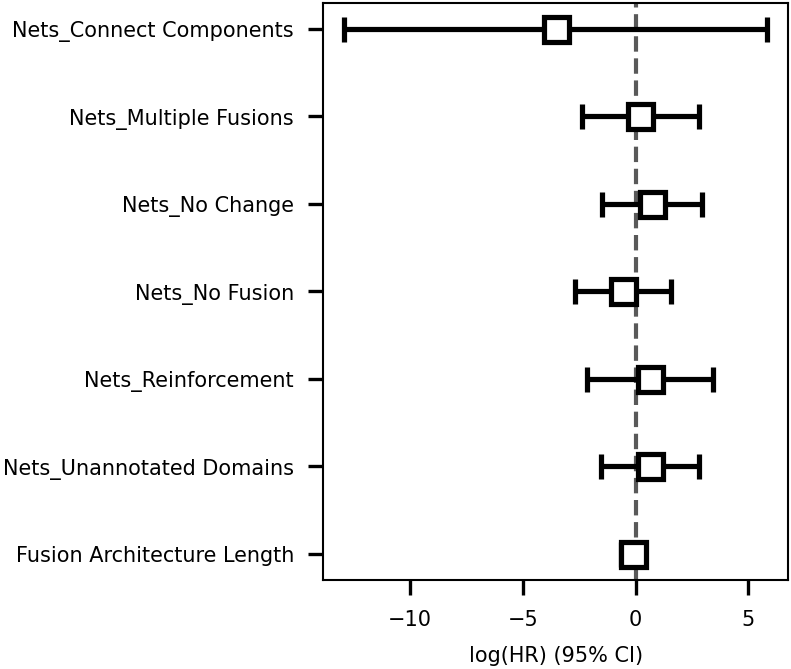

In [50]:
cph=CoxPHFitter(penalizer=.01)
cph.fit(mapped_clin_filt.drop(['Patient ID','Sample ID','TCGA PanCanAtlas Cancer Type Acronym','Cancer Type','Cancer Type Detailed'], axis = 1),duration_col='Overall Survival (Months)', event_col='Overall Survival Status')
cph.plot(columns=[c for c in mapped_clin_filt if 'Nets' in c]+['Fusion Architecture Length'])
plt.gcf().set_dpi(300)
plt.gcf().set_size_inches(2,2.5)
plt.show()

In [51]:
cph.print_summary(columns=['coef','exp(coef)','p'])

<lifelines.CoxPHFitter: fitted with 501 total observations, 342 right-censored observations>
             duration col = 'Overall Survival (Months)'
                event col = 'Overall Survival Status'
                penalizer = 0.01
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 501
number of events observed = 159
   partial log-likelihood = -842.40
         time fit was run = 2024-11-17 23:56:40 UTC

---
                             coef  exp(coef)      p
covariate                                          
Diagnosis Age                0.03       1.03 <0.005
Sex                          0.01       1.01   0.94
Fusion Architecture Length  -0.12       0.88   0.63
Nets_Connect Components     -3.55       0.03   0.46
Nets_Multiple Fusions        0.21       1.24   0.87
Nets_No Change               0.74       2.10   0.51
Nets_No Fusion              -0.55       0.58   0.61
Nets_Reinforcement           0.64       1.89   0.66
Nets_Unannotated Domains     0.64       1.90   0.57
Stage_T1                    -1.02       0.36   0.21
Stage_T1A                   -0.60       0.55   0.26
Stage_T1B                   -0.42       0.66   0.43
Stage_T2                     0.04       1.04   0.95
Stage_T2A                   -0.58       0.56   0.58
Stage_T2B                    0.51       1.66   0.56
Stage_T3                     0.76       2.14   0.49
Stage_T3A                    0.64       1.90   0.21
Stage_T3B                    0.65       1.91   0.23
Stage_T3C                    1.43       4.16   0.10
Stage_T4                     1.79       5.99 <0.005
---
Concordance = 0.73
Partial AIC = 1724.81
log-likelihood ratio test = 96.96 on 20 df
-log2(p) of ll-ratio test = 37.73

As a validation that all the KM curves were underpowered due to small sample size of each fusion gene category doing a power analysis using the KIRC cohort as this one was identified in both the presence and categories as having a potential difference via the log-rank test. However, as shown above with the CoxPH model those impacts were not maintained. 

In [99]:
mapped_clin_filt.columns

Index(['Patient ID', 'Sample ID', 'Diagnosis Age', 'Cancer Type',
       'TCGA PanCanAtlas Cancer Type Acronym', 'Sex',
       'Overall Survival (Months)', 'Overall Survival Status',
       'Cancer Type Detailed', 'Fusion Architecture Length',
       'Nets_Connect Components', 'Nets_Multiple Fusions', 'Nets_No Change',
       'Nets_No Fusion', 'Nets_Reinforcement', 'Nets_Unannotated Domains',
       'Stage_T1', 'Stage_T1A', 'Stage_T1B', 'Stage_T2', 'Stage_T2A',
       'Stage_T2B', 'Stage_T3', 'Stage_T3A', 'Stage_T3B', 'Stage_T3C',
       'Stage_T4'],
      dtype='object')

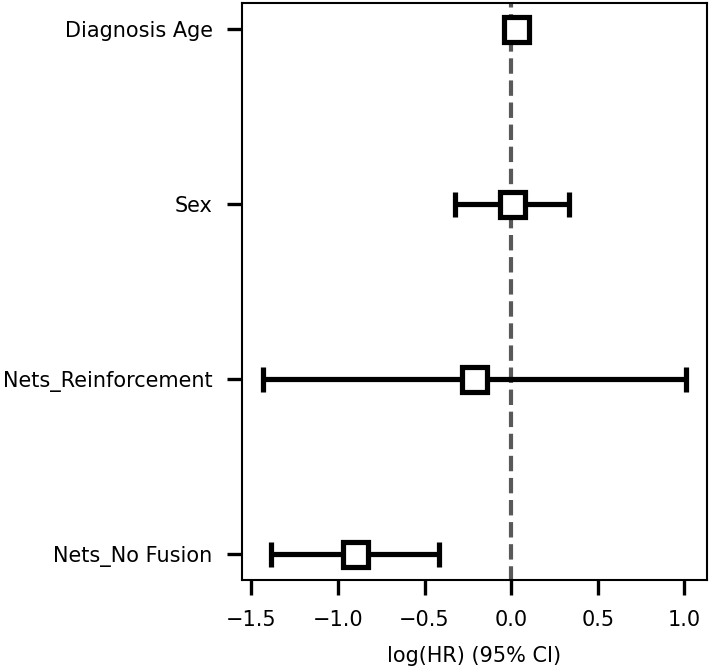

<lifelines.CoxPHFitter: fitted with 501 total observations, 342 right-censored observations>
             duration col = 'Overall Survival (Months)'
                event col = 'Overall Survival Status'
                penalizer = 0.01
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 501
number of events observed = 159
   partial log-likelihood = -845.62
         time fit was run = 2024-11-18 20:49:01 UTC

---
                     coef  exp(coef)      p
covariate                                  
Nets_No Fusion      -0.90       0.41 <0.005
Nets_Reinforcement  -0.21       0.81   0.73
Diagnosis Age        0.03       1.03 <0.005
Sex                  0.00       1.00   0.98
Stage_T1            -1.02       0.36   0.21
Stage_T1A           -0.57       0.56   0.28
Stage_T1B           -0.40       0.67   0.45
Stage_T2             0.02       1.02   0.97
Stage_T2A           -0.55       0.58   0.60
Stage_T2B            0.50       1.65   0.56
Stage_T3             0.74       2.10   0.50
Stage_T3A            0.66       1.93   0.20
Stage_T3B            0.55       1.73   0.31
Stage_T3C            1.42       4.12   0.11
Stage_T4             1.81       6.09 <0.005
---
Concordance = 0.73
Partial AIC = 1721.23
log-likelihood ratio test = 90.54 on 15 df
-log2(p) of ll-ratio test = 40.21

In [108]:
# Here showing what happens when a CoxPH model is fitted to the Reinforcement v. no Fusion only
cph=CoxPHFitter(penalizer=.01)
cph.fit(mapped_clin_filt.filter(['Nets_No Fusion','Nets_Reinforcement','Diagnosis Age','Sex','Overall Survival (Months)','Overall Survival Status','Stage_T1', 'Stage_T1A', 'Stage_T1B', 'Stage_T2', 'Stage_T2A',
       'Stage_T2B', 'Stage_T3', 'Stage_T3A', 'Stage_T3B', 'Stage_T3C',
       'Stage_T4'], axis = 1),duration_col='Overall Survival (Months)', event_col='Overall Survival Status')
cph.plot(['Diagnosis Age','Sex','Nets_Reinforcement','Nets_No Fusion'])
plt.gcf().set_dpi(300)
plt.gcf().set_size_inches(2,2.5)
plt.show()
cph.print_summary(columns=['coef','exp(coef)','p'])

In [94]:
from lifelines.statistics import power_under_cph,sample_size_necessary_under_cph

In [130]:
# Here showing the power for the Reinforcement which was suggested via log-rank but when checked with co-variates loses significance.
rein_num = sum(mapped_clin_filt['Nets_Reinforcement'])
nofus_num = sum(mapped_clin_filt['Nets_No Fusion'])
rhr=cph.summary.loc['Nets_Reinforcement','exp(coef)']/cph.summary.loc['Nets_No Fusion','exp(coef)']
power_under_cph(rein_num,nofus_num,0.22,0.2,rhr)

0.25160609088729335

In [131]:
rhr

1.9890996169405581

In [132]:
# Checking what the sample size would have to be in order to reach the 
sample_size_necessary_under_cph(0.8,rein_num/(rein_num+nofus_num),0.22,0.2,rhr)

(43, 2180)

The above for HNSC is fairly representative of the effects that are seen across all the cancers suggesting that the fusion gene domain architectures cannot fully explain differences in overall survival probability. Thus, while fusion genes can link distinct domain families the variety of domains involved in fusions may limit their predictive capacity or highlight underlying principles guiding domain architecture evolution.